# Guided Project: Task 2A: Image-Caption Retrieval with CLIP

This notebook implements image-to-caption retrieval using CLIP (Contrastive Language-Image Pretraining).

## Names
1. Diego Bermudez Sierra - dabermud@andrew.cmu.edu
2. Santiago Bolaños Vega - sbolaosv@andrew.cmu.edu

## Objectives:
1. Load pretrained CLIP model from Hugging Face
2. Compute embeddings for images and captions
3. Perform image-to-caption retrieval using cosine similarity
4. Evaluate retrieval performance with multiple metrics:
   - Recall@K (instance-level and class-aware)
   - BERTScore
   - CLIPScore
   - Mean Average Precision (MAP)

## AI Acknowledgement


## 1. Set-up: Installation and Imports

In [1]:
import torch
import torch.nn.functional as F
from transformers import CLIPModel, CLIPProcessor
from PIL import Image
import pandas as pd
import numpy as np
import os
from pathlib import Path
from tqdm import tqdm
import json
from bert_score import score as bert_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import average_precision_score
import random
import matplotlib.pyplot as plt
from PIL import Image


import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## 2. CLIP Model Loading


In [2]:
# Load CLIP model and processor
model_name = "openai/clip-vit-base-patch32"
print(f"Loading CLIP model: {model_name}")

model = CLIPModel.from_pretrained(model_name, use_safetensors=True).to(device)
processor = CLIPProcessor.from_pretrained(model_name)

# Set model to evaluation mode
model.eval()

print("CLIP model loaded successfully!")
print(f"Image encoder: {model.vision_model.__class__.__name__}")
print(f"Text encoder: {model.text_model.__class__.__name__}")
print(f"Embedding dimension: {model.config.projection_dim}")

Loading CLIP model: openai/clip-vit-base-patch32


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


CLIP model loaded successfully!
Image encoder: CLIPVisionTransformer
Text encoder: CLIPTextTransformer
Embedding dimension: 512


## 2. Data Loading Functions

We need to:

1. **Load captions and metadata** from `captions.txt` (image names, captions, categories)
2. **Resolve image file paths** by searching image directories for matching filenames
3. **Build image-caption pairs** mapping each image path to its caption and category
4. **Handle missing files** by filtering out images that cannot be located

In [3]:
def load_captions(captions_path):
    """
    Load captions from captions.txt file.
    Actual format: dataset, category, image_name, abstracted (caption)
    """
    # Read with header - the file has: dataset, category, image_name, abstracted
    captions_df = pd.read_csv(captions_path, sep='\t', header=0)
    
    # Rename 'abstracted' to 'caption' for consistency
    captions_df = captions_df.rename(columns={'abstracted': 'caption'})
    
    # Keep only the columns we need: image_name, caption, category
    captions_df = captions_df[['image_name', 'caption', 'category']].copy()
    
    # Remove .jpg extension if present in image_name
    captions_df['image_name'] = captions_df['image_name'].str.replace('.jpg', '').str.replace('.jpeg', '').str.replace('.png', '')
    
    return captions_df

def find_image_path(image_name, image_dirs):
    """
    Find image file path given image name.
    Searches in multiple possible directories and handles different extensions.
    """
    extensions = ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG']
    
    for img_dir in image_dirs:
        for ext in extensions:
            img_path = os.path.join(img_dir, f"{image_name}{ext}")
            if os.path.exists(img_path):
                return img_path
            # Also try with extension already in name
            img_path = os.path.join(img_dir, image_name)
            if os.path.exists(img_path):
                return img_path
    
    return None

def load_image_caption_pairs(data_root, image_dirs, captions_path):
    """
    Load all image-caption pairs from the dataset.
    Returns a DataFrame with columns: image_name, image_path, caption, category
    """
    # Load captions
    captions_df = load_captions(captions_path)
    
    # Find image paths
    image_paths = []
    for img_name in tqdm(captions_df['image_name'], desc="Finding image paths"):
        img_path = find_image_path(img_name, image_dirs)
        image_paths.append(img_path)
    
    captions_df['image_path'] = image_paths
    
    # Filter out images that weren't found
    valid_mask = captions_df['image_path'].notna()
    captions_df = captions_df[valid_mask].reset_index(drop=True)
    
    print(f"Loaded {len(captions_df)} valid image-caption pairs")
    print(f"Categories: {captions_df['category'].nunique()}")
    
    return captions_df


In [4]:
# Dataset path (READ-ONLY - do not modify!)
# Path: /ocean/projects/cis2500119p/gandotra/11785-gp-eeg
DATA_ROOT = "/ocean/projects/cis250019p/gandotra/11785-gp-eeg"

# Image directories (check both possible locations)
IMAGE_DIRS = [
    os.path.join(DATA_ROOT, "images"),
    os.path.join(DATA_ROOT, "All_images"),
]

# Captions file
CAPTIONS_PATH = os.path.join(DATA_ROOT, "captions.txt")

# Verify paths exist
print("Checking dataset paths...")
print(f"DATA_ROOT exists: {os.path.exists(DATA_ROOT)}")
print(f"CAPTIONS_PATH exists: {os.path.exists(CAPTIONS_PATH)}")
for img_dir in IMAGE_DIRS:
    print(f"{img_dir} exists: {os.path.exists(img_dir)}")

# Load image-caption pairs
print("\nLoading dataset...")
dataset_df = load_image_caption_pairs(DATA_ROOT, IMAGE_DIRS, CAPTIONS_PATH)

# Display sample
print("\nSample data:")
print(dataset_df.head())


Checking dataset paths...
DATA_ROOT exists: True
CAPTIONS_PATH exists: True
/ocean/projects/cis250019p/gandotra/11785-gp-eeg/images exists: True
/ocean/projects/cis250019p/gandotra/11785-gp-eeg/All_images exists: False

Loading dataset...


Finding image paths: 100%|███████████████| 9825/9825 [00:00<00:00, 33237.01it/s]


Loaded 9825 valid image-caption pairs
Categories: 20

Sample data:
        image_name                                      caption category  \
0   n02835271_1031  Tandem bicycle parked beside a wooden fence  bicycle   
1  n02835271_10424    Tandem bicycle leaning against brick wall  bicycle   
2  n02835271_10469        Bicycle leaning against a wooden post  bicycle   
3   n02835271_1055    Tandem bicycle parked beside green bushes  bicycle   
4  n02835271_10778        Tandem bicycle parked by a brick wall  bicycle   

                                          image_path  
0  /ocean/projects/cis250019p/gandotra/11785-gp-e...  
1  /ocean/projects/cis250019p/gandotra/11785-gp-e...  
2  /ocean/projects/cis250019p/gandotra/11785-gp-e...  
3  /ocean/projects/cis250019p/gandotra/11785-gp-e...  
4  /ocean/projects/cis250019p/gandotra/11785-gp-e...  


Total captions: 9825
Valid images found: 9825


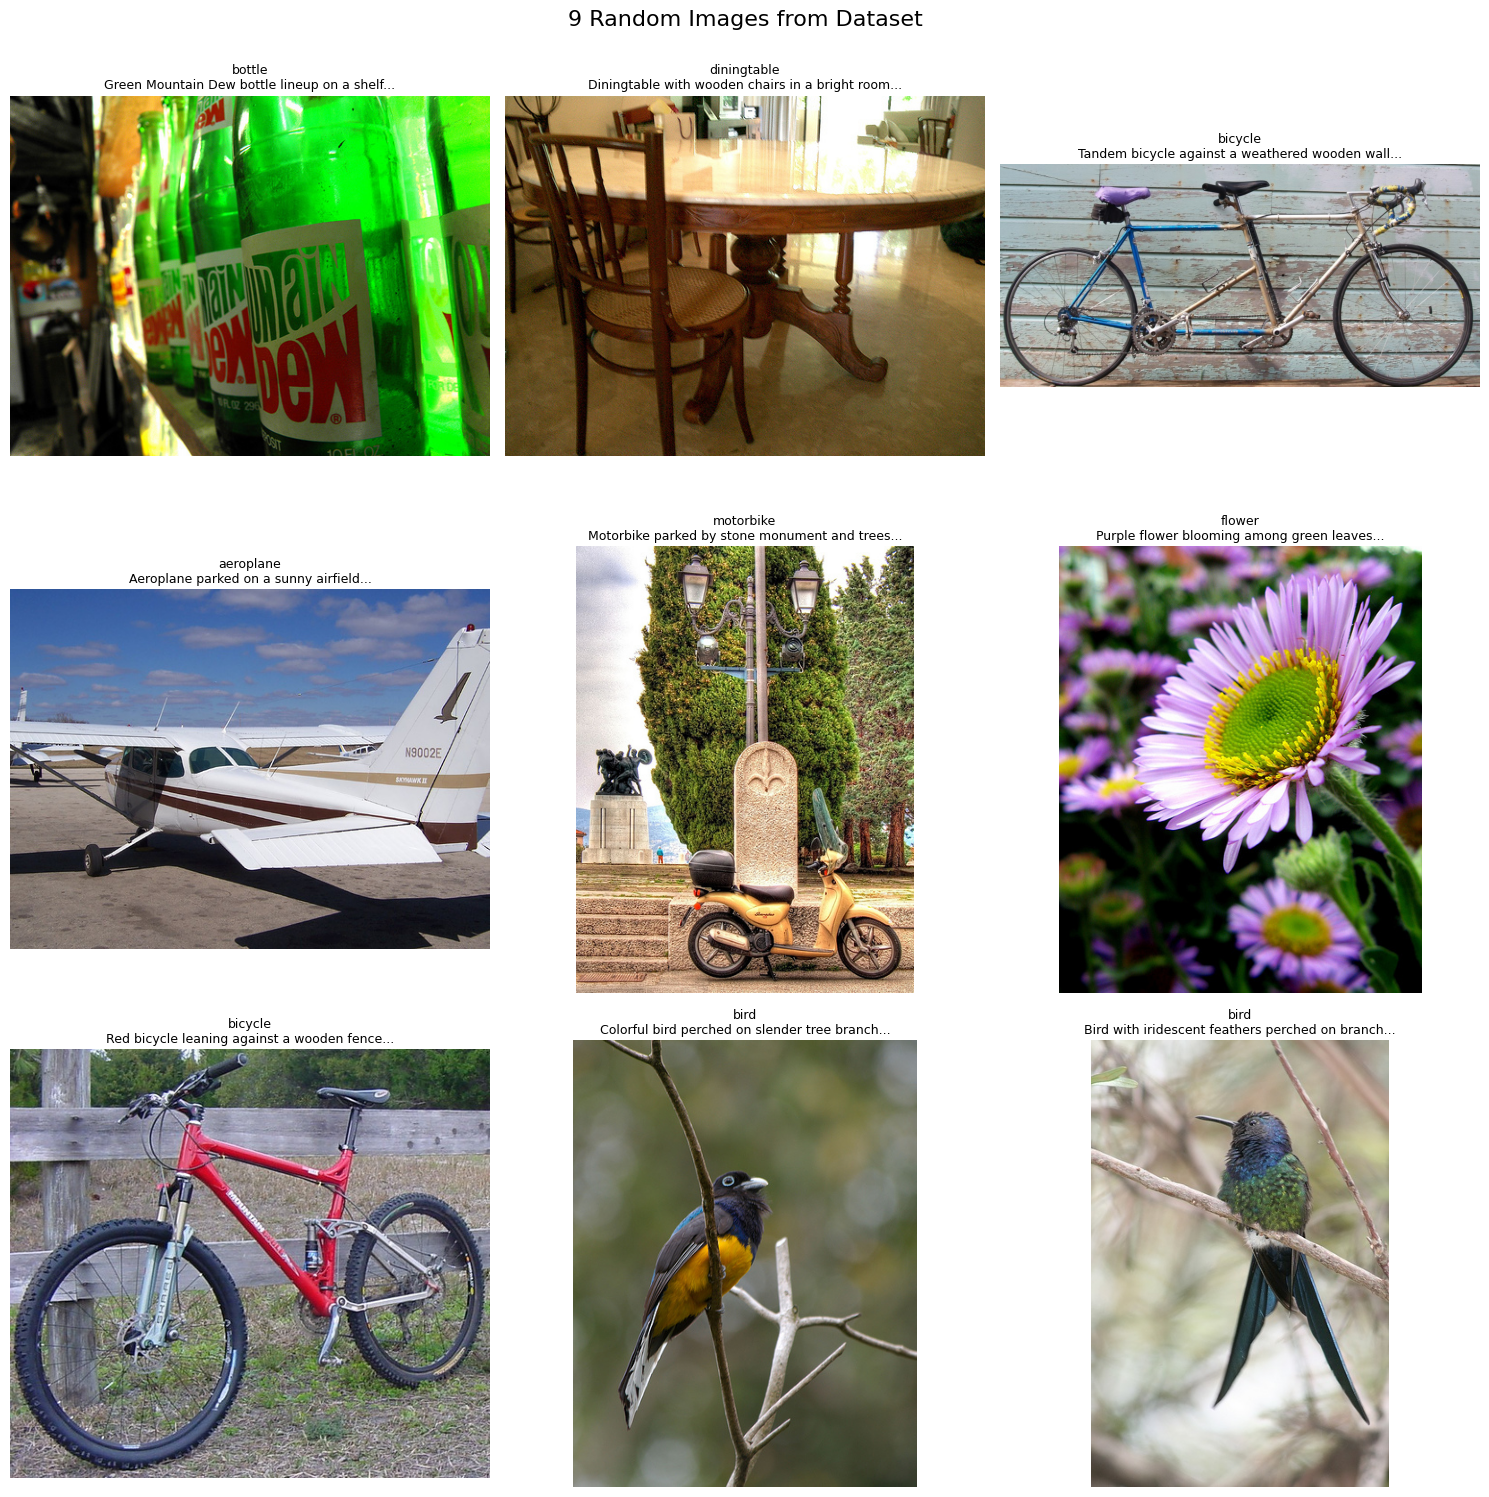

In [5]:
# Load captions and find image paths
captions_df = load_captions(CAPTIONS_PATH)
print(f"Total captions: {len(captions_df)}")

# Find image paths for all captions
image_paths = []
for img_name in captions_df['image_name']:
    img_path = find_image_path(img_name, IMAGE_DIRS)
    image_paths.append(img_path)

captions_df['image_path'] = image_paths

# Filter to only valid images (where path was found)
valid_df = captions_df[captions_df['image_path'].notna()].copy()
print(f"Valid images found: {len(valid_df)}")

# Randomly select 9 images
if len(valid_df) >= 9:
    random_indices = random.sample(range(len(valid_df)), 9)
    selected_df = valid_df.iloc[random_indices].reset_index(drop=True)
    
    # Create 3x3 grid
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    fig.suptitle('9 Random Images from Dataset', fontsize=16, y=0.995)
    
    for idx, (i, row) in enumerate(selected_df.iterrows()):
        ax = axes[idx // 3, idx % 3]
        
        try:
            img = Image.open(row['image_path'])
            ax.imshow(img)
            ax.set_title(f"{row['category']}\n{row['caption'][:50]}...", 
                        fontsize=9, pad=5)
            ax.axis('off')
        except Exception as e:
            ax.text(0.5, 0.5, f"Error loading image:\n{str(e)}", 
                   ha='center', va='center', fontsize=8)
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print(f"Not enough valid images found. Only {len(valid_df)} images available.")

## 4. Compute Embeddings

We'll compute embeddings for all images and captions in batches for efficiency.


In [6]:
def compute_image_embeddings(model, processor, image_paths, batch_size=32, device='cuda'):
    """
    Compute CLIP embeddings for a list of images.
    """
    model.eval()
    embeddings = []
    
    with torch.no_grad():
        for i in tqdm(range(0, len(image_paths), batch_size), desc="Computing image embeddings"):
            batch_paths = image_paths[i:i+batch_size]
            
            # Load and preprocess images
            images = []
            valid_indices = []
            for j, img_path in enumerate(batch_paths):
                try:
                    img = Image.open(img_path).convert('RGB')
                    images.append(img)
                    valid_indices.append(i + j)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
                    continue
            
            if not images:
                continue
            
            # Process images
            inputs = processor(images=images, return_tensors="pt", padding=True).to(device)
            
            # Get image embeddings
            image_features = model.get_image_features(**inputs)
            
            # Normalize embeddings
            image_features = F.normalize(image_features, p=2, dim=1)
            
            # Store embeddings (handle missing images)
            batch_embeddings = torch.zeros(len(batch_paths), image_features.shape[1], device=device)
            for idx, valid_idx in enumerate(valid_indices):
                batch_embeddings[valid_idx - i] = image_features[idx]
            
            embeddings.append(batch_embeddings.cpu())
    
    return torch.cat(embeddings, dim=0)

def compute_text_embeddings(model, processor, texts, batch_size=32, device='cuda'):
    """
    Compute CLIP embeddings for a list of text captions.
    """
    model.eval()
    embeddings = []
    
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Computing text embeddings"):
            batch_texts = texts[i:i+batch_size]
            
            # Process texts
            inputs = processor(text=batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)
            
            # Get text embeddings
            text_features = model.get_text_features(**inputs)
            
            # Normalize embeddings
            text_features = F.normalize(text_features, p=2, dim=1)
            
            embeddings.append(text_features.cpu())
    
    return torch.cat(embeddings, dim=0)


In [7]:
# Compute embeddings for all images and captions
print("Computing image embeddings...")
image_embeddings = compute_image_embeddings(
    model, processor, 
    dataset_df['image_path'].tolist(), 
    batch_size=32, 
    device=device
)

print("Computing text embeddings...")
text_embeddings = compute_text_embeddings(
    model, processor,
    dataset_df['caption'].tolist(),
    batch_size=32,
    device=device
)

print(f"\nImage embeddings shape: {image_embeddings.shape}")
print(f"Text embeddings shape: {text_embeddings.shape}")


Computing image embeddings...


Computing image embeddings: 100%|█████████████| 308/308 [01:24<00:00,  3.64it/s]


Computing text embeddings...


Computing text embeddings: 100%|█████████████| 308/308 [00:02<00:00, 147.02it/s]


Image embeddings shape: torch.Size([9825, 512])
Text embeddings shape: torch.Size([9825, 512])


## 5. Image-to-Caption Retrieval

Implement retrieval using cosine similarity.


In [8]:
def retrieve_captions(image_embedding, caption_embeddings, k=5):
    """
    Retrieve top-K captions for a given image embedding.
    
    Args:
        image_embedding: Single image embedding (1, d)
        caption_embeddings: All caption embeddings (N, d)
        k: Number of top captions to retrieve
    
    Returns:
        top_k_indices: Indices of top-K captions
        top_k_scores: Similarity scores for top-K captions
    """
    # Compute cosine similarity (dot product since embeddings are normalized)
    similarities = torch.matmul(image_embedding, caption_embeddings.T)  # (1, N)
    
    # Get top-K indices
    top_k_scores, top_k_indices = torch.topk(similarities, k=k, dim=1)
    
    return top_k_indices.squeeze(0).cpu().numpy(), top_k_scores.squeeze(0).cpu().numpy()

def batch_retrieve_captions(image_embeddings, caption_embeddings, k=5):
    """
    Retrieve top-K captions for all images.
    
    Returns:
        all_top_k_indices: (N_images, k) array of caption indices
        all_top_k_scores: (N_images, k) array of similarity scores
    """
    # Move to device if needed
    if image_embeddings.device != caption_embeddings.device:
        image_embeddings = image_embeddings.to(caption_embeddings.device)
    
    # Compute similarity matrix
    similarity_matrix = torch.matmul(image_embeddings, caption_embeddings.T)  # (N_images, N_captions)
    
    # Get top-K for each image
    top_k_scores, top_k_indices = torch.topk(similarity_matrix, k=k, dim=1)
    
    return top_k_indices.cpu().numpy(), top_k_scores.cpu().numpy()


In [9]:
# Perform retrieval for all images
print("Performing retrieval...")
image_embeddings_gpu = image_embeddings.to(device)
text_embeddings_gpu = text_embeddings.to(device)

# Get top-5 retrievals
top_k = 5
retrieved_indices, retrieved_scores = batch_retrieve_captions(
    image_embeddings_gpu, text_embeddings_gpu, k=top_k
)

print(f"Retrieved top-{top_k} captions for {len(retrieved_indices)} images")


Performing retrieval...
Retrieved top-5 captions for 9825 images


## 6. Evaluation Metrics

Implement all required evaluation metrics.


In [10]:
def compute_recall_at_k(retrieved_indices, ground_truth_indices, k_values=[1, 3, 5], instance_level=True):
    """
    Compute Recall@K metrics.
    
    Args:
        retrieved_indices: (N_images, max_k) array of retrieved caption indices
        ground_truth_indices: (N_images,) array of ground truth caption indices
        k_values: List of K values to compute
        instance_level: If True, exact match required. If False, class-aware.
    
    Returns:
        Dictionary of Recall@K scores
    """
    recalls = {}
    
    for k in k_values:
        if k > retrieved_indices.shape[1]:
            continue
        
        correct = 0
        for i, gt_idx in enumerate(ground_truth_indices):
            top_k_retrieved = retrieved_indices[i, :k]
            if instance_level:
                # Instance-level: exact caption match
                if gt_idx in top_k_retrieved:
                    correct += 1
            else:
                # Class-aware: any caption from same category
                # This requires category information - will be implemented below
                if gt_idx in top_k_retrieved:
                    correct += 1
        
        recalls[f'Recall@{k}'] = correct / len(ground_truth_indices)
    
    return recalls

def compute_recall_at_k_class_aware(retrieved_indices, ground_truth_indices, categories, k_values=[1, 3, 5]):
    """
    Compute class-aware Recall@K (any caption from same category counts as correct).
    """
    recalls = {}
    
    # Create category mapping
    category_map = {}
    for idx, cat in enumerate(categories):
        if cat not in category_map:
            category_map[cat] = []
        category_map[cat].append(idx)
    
    for k in k_values:
        if k > retrieved_indices.shape[1]:
            continue
        
        correct = 0
        for i, gt_idx in enumerate(ground_truth_indices):
            gt_category = categories[gt_idx]
            top_k_retrieved = retrieved_indices[i, :k]
            
            # Check if any retrieved caption is from the same category
            found = False
            for ret_idx in top_k_retrieved:
                if categories[ret_idx] == gt_category:
                    found = True
                    break
            
            if found:
                correct += 1
        
        recalls[f'Class-aware Recall@{k}'] = correct / len(ground_truth_indices)
    
    return recalls

def compute_map_caption_level(similarity_matrix, ground_truth_indices):
    """
    Compute Mean Average Precision (MAP) at caption level.
    Only exact ground-truth caption is considered relevant.
    """
    aps = []
    
    for i, gt_idx in enumerate(ground_truth_indices):
        # Get similarity scores for this image
        scores = similarity_matrix[i].cpu().numpy()
        
        # Create binary relevance labels (only ground truth is relevant)
        y_true = np.zeros(len(scores))
        y_true[gt_idx] = 1
        
        # Compute average precision
        ap = average_precision_score(y_true, scores)
        aps.append(ap)
    
    return np.mean(aps)

def compute_map_class_aware(similarity_matrix, ground_truth_indices, categories):
    """
    Compute class-aware MAP (any caption from same category is relevant).
    """
    aps = []
    
    # Create category mapping
    category_map = {}
    for idx, cat in enumerate(categories):
        if cat not in category_map:
            category_map[cat] = []
        category_map[cat].append(idx)
    
    for i, gt_idx in enumerate(ground_truth_indices):
        gt_category = categories[gt_idx]
        
        # Get similarity scores for this image
        scores = similarity_matrix[i].cpu().numpy()
        
        # Create binary relevance labels (all captions from same category are relevant)
        y_true = np.zeros(len(scores))
        for relevant_idx in category_map[gt_category]:
            y_true[relevant_idx] = 1
        
        # Compute average precision
        ap = average_precision_score(y_true, scores)
        aps.append(ap)
    
    return np.mean(aps)

def compute_map_per_class(similarity_matrix, ground_truth_indices, categories):
    """
    Compute MAP separately for each semantic class.
    """
    unique_categories = sorted(set(categories))
    map_per_class = {}
    
    for cat in unique_categories:
        # Get indices for this category
        cat_indices = [i for i, c in enumerate(categories) if c == cat]
        
        if not cat_indices:
            continue
        
        # Compute MAP for this category
        cat_aps = []
        for i, gt_idx in enumerate(ground_truth_indices):
            if categories[gt_idx] != cat:
                continue
            
            scores = similarity_matrix[i].cpu().numpy()
            y_true = np.zeros(len(scores))
            y_true[gt_idx] = 1
            
            ap = average_precision_score(y_true, scores)
            cat_aps.append(ap)
        
        map_per_class[cat] = np.mean(cat_aps) if cat_aps else 0.0
    
    return map_per_class


In [11]:
# Ground truth indices (each image's true caption index)
ground_truth_indices = np.arange(len(dataset_df))  # Assuming 1-to-1 mapping

# Compute similarity matrix for MAP calculation
similarity_matrix = torch.matmul(image_embeddings_gpu, text_embeddings_gpu.T)

# Compute Recall@K metrics
print("Computing Recall@K metrics...")
recall_instance = compute_recall_at_k(
    retrieved_indices, ground_truth_indices, k_values=[1, 3, 5], instance_level=True
)
recall_class_aware = compute_recall_at_k_class_aware(
    retrieved_indices, ground_truth_indices, 
    dataset_df['category'].values, k_values=[1, 3, 5]
)

print("\n=== Recall Metrics ===")
for k, score in recall_instance.items():
    print(f"{k}: {score:.4f}")
for k, score in recall_class_aware.items():
    print(f"{k}: {score:.4f}")

# Compute MAP metrics
print("\nComputing MAP metrics...")
map_caption = compute_map_caption_level(similarity_matrix, ground_truth_indices)
map_class_aware = compute_map_class_aware(
    similarity_matrix, ground_truth_indices, dataset_df['category'].values
)
map_per_class = compute_map_per_class(
    similarity_matrix, ground_truth_indices, dataset_df['category'].values
)

print("\n=== MAP Metrics ===")
print(f"Caption-level MAP: {map_caption:.4f}")
print(f"Class-aware MAP: {map_class_aware:.4f}")
print("\nPer-class MAP:")
for cat, score in sorted(map_per_class.items()):
    print(f"  {cat}: {score:.4f}")


Computing Recall@K metrics...

=== Recall Metrics ===
Recall@1: 0.1982
Recall@3: 0.3270
Recall@5: 0.3950
Class-aware Recall@1: 0.9699
Class-aware Recall@3: 0.9825
Class-aware Recall@5: 0.9851

Computing MAP metrics...

=== MAP Metrics ===
Caption-level MAP: 0.2980
Class-aware MAP: 0.8305

Per-class MAP:
  aeroplane: 0.1832
  bicycle: 0.2737
  bird: 0.3845
  boat: 0.1558
  bottle: 0.4389
  bus: 0.2013
  car: 0.3972
  cat: 0.4781
  chair: 0.3681
  cow: 0.1949
  diningtable: 0.1902
  dog: 0.4982
  flower: 0.1442
  horse: 0.2014
  motorbike: 0.3002
  person: 0.5480
  sheep: 0.1208
  sofa: 0.3457
  train: 0.2751
  tvmonitor: 0.2559


## 7. Semantic Metrics: BERTScore and CLIPScore


In [12]:
def compute_clipscore(image_embeddings, text_embeddings, retrieved_indices, ground_truth_indices):
    """
    Compute CLIPScore for retrieved captions.
    CLIPScore = cosine similarity between image and text embeddings.
    """
    clip_scores = []
    
    for i, gt_idx in enumerate(ground_truth_indices):
        # Get top-1 retrieved caption
        ret_idx = retrieved_indices[i, 0]
        
        # Compute similarity between image and retrieved caption
        img_emb = image_embeddings[i:i+1]
        txt_emb = text_embeddings[ret_idx:ret_idx+1]
        similarity = torch.matmul(img_emb, txt_emb.T).item()
        
        clip_scores.append(similarity)
    
    return np.array(clip_scores)

def compute_bertscore_batch(candidates, references, batch_size=32):
    """
    Compute BERTScore for candidate and reference captions.
    """
    all_scores = []
    
    for i in tqdm(range(0, len(candidates), batch_size), desc="Computing BERTScore"):
        batch_candidates = candidates[i:i+batch_size]
        batch_references = references[i:i+batch_size]
        
        P, R, F1 = bert_score(
            batch_candidates, batch_references,
            lang='en', verbose=False, device=device
        )
        
        all_scores.append(F1.cpu().numpy())
    
    return np.concatenate(all_scores)


In [13]:
# Compute CLIPScore
print("Computing CLIPScore...")
clip_scores = compute_clipscore(
    image_embeddings_gpu, text_embeddings_gpu,
    retrieved_indices, ground_truth_indices
)

print(f"CLIPScore - Mean: {clip_scores.mean():.4f}, Std: {clip_scores.std():.4f}")
print(f"CLIPScore - Min: {clip_scores.min():.4f}, Max: {clip_scores.max():.4f}")

# Compute BERTScore for top-1 retrievals
print("\nComputing BERTScore...")
retrieved_captions = [dataset_df.iloc[retrieved_indices[i, 0]]['caption'] for i in range(len(ground_truth_indices))]
ground_truth_captions = dataset_df['caption'].tolist()

# Sample a subset for BERTScore (it can be slow for large datasets)
sample_size = min(1000, len(ground_truth_captions))
sample_indices = np.random.choice(len(ground_truth_captions), sample_size, replace=False)

sample_retrieved = [retrieved_captions[i] for i in sample_indices]
sample_ground_truth = [ground_truth_captions[i] for i in sample_indices]

bert_scores = compute_bertscore_batch(sample_retrieved, sample_ground_truth)

print(f"\nBERTScore F1 - Mean: {bert_scores.mean():.4f}, Std: {bert_scores.std():.4f}")
print(f"High similarity rate (F1 > 0.7): {(bert_scores > 0.7).mean():.4f}")


Computing CLIPScore...
CLIPScore - Mean: 0.3223, Std: 0.0237
CLIPScore - Min: 0.2425, Max: 0.4579

Computing BERTScore...


Computing BERTScore:   0%|                               | 0/32 [00:00<?, ?it/s]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Computing BERTScore:   3%|▋                      | 1/32 [00:01<00:31,  1.02s/it]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Computing BERTScore:   6%|█▍                     | 2/32 [00:01<00:29,  1.02it/s]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a d


BERTScore F1 - Mean: 0.9243, Std: 0.0474
High similarity rate (F1 > 0.7): 1.0000


## 8. Analysis and Visualization


Analyzing CLIPScore distribution...

Matched pairs - Mean: 0.3021, Std: 0.0303
Mismatched pairs - Mean: 0.1411, Std: 0.0416


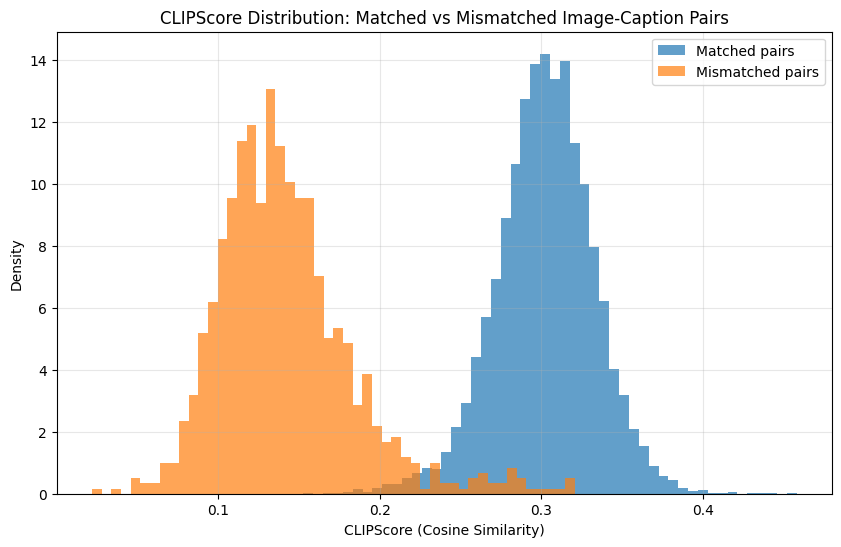

In [14]:
# Compare CLIPScore for matched vs mismatched pairs
print("Analyzing CLIPScore distribution...")

# Matched pairs (ground truth)
matched_scores = []
for i, gt_idx in enumerate(ground_truth_indices):
    img_emb = image_embeddings_gpu[i:i+1]
    txt_emb = text_embeddings_gpu[gt_idx:gt_idx+1]
    similarity = torch.matmul(img_emb, txt_emb.T).item()
    matched_scores.append(similarity)

# Mismatched pairs (random negative samples)
mismatched_scores = []
for i in range(min(1000, len(ground_truth_indices))):
    img_emb = image_embeddings_gpu[i:i+1]
    # Random negative caption
    neg_idx = np.random.choice([j for j in range(len(text_embeddings_gpu)) if j != ground_truth_indices[i]])
    txt_emb = text_embeddings_gpu[neg_idx:neg_idx+1]
    similarity = torch.matmul(img_emb, txt_emb.T).item()
    mismatched_scores.append(similarity)

matched_scores = np.array(matched_scores)
mismatched_scores = np.array(mismatched_scores)

print(f"\nMatched pairs - Mean: {matched_scores.mean():.4f}, Std: {matched_scores.std():.4f}")
print(f"Mismatched pairs - Mean: {mismatched_scores.mean():.4f}, Std: {mismatched_scores.std():.4f}")

# Visualization
plt.figure(figsize=(10, 6))
plt.hist(matched_scores, bins=50, alpha=0.7, label='Matched pairs', density=True)
plt.hist(mismatched_scores, bins=50, alpha=0.7, label='Mismatched pairs', density=True)
plt.xlabel('CLIPScore (Cosine Similarity)')
plt.ylabel('Density')
plt.title('CLIPScore Distribution: Matched vs Mismatched Image-Caption Pairs')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [15]:
# Visualize some retrieval examples
def visualize_retrieval_examples(dataset_df, retrieved_indices, ground_truth_indices, 
                                 image_embeddings_gpu, text_embeddings_gpu, 
                                 num_examples=5, top_k=3):
    """
    Visualize retrieval examples with images and captions.
    """
    fig, axes = plt.subplots(num_examples, top_k + 1, figsize=(15, 3*num_examples))
    
    for i in range(num_examples):
        idx = i * (len(ground_truth_indices) // num_examples)
        gt_idx = ground_truth_indices[idx]
        
        # Load and display query image
        try:
            img = Image.open(dataset_df.iloc[idx]['image_path'])
            axes[i, 0].imshow(img)
            axes[i, 0].set_title(f"Query Image\nGT: {dataset_df.iloc[gt_idx]['caption'][:50]}...")
            axes[i, 0].axis('off')
        except:
            axes[i, 0].text(0.5, 0.5, 'Image not found', ha='center', va='center')
            axes[i, 0].axis('off')
        
        # Display retrieved captions
        for j in range(top_k):
            ret_idx = retrieved_indices[idx, j]
            ret_caption = dataset_df.iloc[ret_idx]['caption']
            similarity = torch.matmul(
                image_embeddings_gpu[idx:idx+1],
                text_embeddings_gpu[ret_idx:ret_idx+1].T
            ).item()
            
            # Color: green if correct, red if wrong
            color = 'green' if ret_idx == gt_idx else 'red'
            axes[i, j+1].text(0.1, 0.5, f"Rank {j+1}\n{ret_caption[:80]}...\nSim: {similarity:.3f}",
                           ha='left', va='center', fontsize=9, 
                           bbox=dict(boxstyle='round', facecolor=color, alpha=0.3))
            axes[i, j+1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Uncomment to visualize (requires images to be loaded)
# visualize_retrieval_examples(dataset_df, retrieved_indices, ground_truth_indices,
#                              image_embeddings_gpu, text_embeddings_gpu, num_examples=5)


## 9. Summary Report

Compile all results into a summary.


In [16]:
# Compile summary report
print("=" * 60)
print("TASK 2A: IMAGE-CAPTION RETRIEVAL WITH CLIP - RESULTS SUMMARY")
print("=" * 60)

print("\n1. RETRIEVAL METRICS (Recall@K)")
print("-" * 60)
for k, score in recall_instance.items():
    print(f"  {k:25s}: {score:.4f}")
for k, score in recall_class_aware.items():
    print(f"  {k:25s}: {score:.4f}")

print("\n2. MEAN AVERAGE PRECISION (MAP)")
print("-" * 60)
print(f"  Caption-level MAP:        {map_caption:.4f}")
print(f"  Class-aware MAP:           {map_class_aware:.4f}")

print("\n3. SEMANTIC METRICS")
print("-" * 60)
print(f"  CLIPScore (mean):          {clip_scores.mean():.4f} ± {clip_scores.std():.4f}")
print(f"  CLIPScore (matched):       {matched_scores.mean():.4f} ± {matched_scores.std():.4f}")
print(f"  CLIPScore (mismatched):     {mismatched_scores.mean():.4f} ± {mismatched_scores.std():.4f}")
print(f"  BERTScore F1 (mean):       {bert_scores.mean():.4f} ± {bert_scores.std():.4f}")
print(f"  High similarity rate (>0.7): {(bert_scores > 0.7).mean():.4f}")

print("\n4. PER-CLASS MAP")
print("-" * 60)
for cat, score in sorted(map_per_class.items()):
    print(f"  {str(cat):20s}: {score:.4f}")

print("\n" + "=" * 60)
print("Analysis:")
print("-" * 60)
print(f"• Instance-level Recall@1: {recall_instance['Recall@1']:.2%} - CLIP can retrieve")
print(f"  the exact ground-truth caption for {recall_instance['Recall@1']:.2%} of images.")
print(f"• Class-aware Recall@5: {recall_class_aware['Class-aware Recall@5']:.2%} - CLIP can")
print(f"  retrieve a caption from the same category for {recall_class_aware['Class-aware Recall@5']:.2%} of images.")
print(f"• CLIPScore separation: {matched_scores.mean() - mismatched_scores.mean():.4f} difference")
print(f"  between matched and mismatched pairs indicates good alignment.")
print("=" * 60)


TASK 2A: IMAGE-CAPTION RETRIEVAL WITH CLIP - RESULTS SUMMARY

1. RETRIEVAL METRICS (Recall@K)
------------------------------------------------------------
  Recall@1                 : 0.1982
  Recall@3                 : 0.3270
  Recall@5                 : 0.3950
  Class-aware Recall@1     : 0.9699
  Class-aware Recall@3     : 0.9825
  Class-aware Recall@5     : 0.9851

2. MEAN AVERAGE PRECISION (MAP)
------------------------------------------------------------
  Caption-level MAP:        0.2980
  Class-aware MAP:           0.8305

3. SEMANTIC METRICS
------------------------------------------------------------
  CLIPScore (mean):          0.3223 ± 0.0237
  CLIPScore (matched):       0.3021 ± 0.0303
  CLIPScore (mismatched):     0.1411 ± 0.0416
  BERTScore F1 (mean):       0.9243 ± 0.0474
  High similarity rate (>0.7): 1.0000

4. PER-CLASS MAP
------------------------------------------------------------
  aeroplane           : 0.1832
  bicycle             : 0.2737
  bird                